In [ ]:
!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import copy
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import sklearn
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1ElQxGUD2weXFtm3_y2Icz8eK1k3JNode/view?usp=sharing'

In [ ]:
fluff, id = link.split('=')
id = link.split('/')[5]

In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('credit_card_approval.csv')  
data = pd.read_csv('credit_card_approval.csv')


In [ ]:
data_copy = copy.deepcopy(data)

<h4>Excerpt from full code</h4>
<h6>Full code can be found at: github.com/manavvshah321/projects</h6>

In [ ]:
data_copy.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
0,5065438,F,Y,N,2+ children,270000.0,Secondary / secondary special,Married,With parents,-13258,-2300,1,0,0,0,Managers,-6,C,0
1,5142753,F,N,N,No children,81000.0,Secondary / secondary special,Single / not married,House / apartment,-17876,-377,1,1,1,0,Private service staff,-4,0,0
2,5111146,M,Y,Y,No children,270000.0,Higher education,Married,House / apartment,-19579,-1028,1,0,1,0,Laborers,0,C,0
3,5010310,F,Y,Y,1 children,112500.0,Secondary / secondary special,Married,House / apartment,-15109,-1956,1,0,0,0,Core staff,-3,0,0
4,5010835,M,Y,Y,2+ children,139500.0,Secondary / secondary special,Married,House / apartment,-17281,-5578,1,1,0,0,Drivers,-29,0,0


In [ ]:
data_copy['age_years'] = round(data_copy['DAYS_BIRTH']/-365,0).astype(int)
data_copy['years_employed'] = round(data_copy['DAYS_EMPLOYED']/-365,0).astype(int)

label_encoder = preprocessing.LabelEncoder()
data_copy['CODE_GENDER'] = label_encoder.fit_transform(data['CODE_GENDER'])
data_copy['FLAG_OWN_CAR'] = label_encoder.fit_transform(data['FLAG_OWN_CAR'])
data_copy['FLAG_OWN_REALTY'] = label_encoder.fit_transform(data['FLAG_OWN_REALTY'])
data_copy['STATUS'] = data_copy['STATUS'].replace(['X'],0)
data_copy['STATUS'] = data_copy['STATUS'].replace(['C'],0)
data_copy['STATUS'] = data_copy['STATUS'].apply(pd.to_numeric) 

data_copy['high_risk'] = np.where(data_copy['STATUS']<1, 0, 1)

pd.get_dummies(data = data_copy, columns = ['NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'JOB'])
rated_dummies = pd.get_dummies(data = data_copy, columns = ['NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'JOB'])
OHEdata = pd.concat([data_copy, rated_dummies], axis=1)
new_data = OHEdata.drop(['ID', 'STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_CHILDREN', 'FLAG_OWN_CAR', 
                         'FLAG_OWN_REALTY', 'BEGIN_MONTHS', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'JOB'], axis = 1)

new_data = new_data.loc[:,~new_data.columns.duplicated()]
new_data.head()


,CODE_GENDER,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,TARGET,age_years,years_employed,high_risk,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,JOB_Accountants,JOB_Cleaning staff,JOB_Cooking staff,JOB_Core staff,JOB_Drivers,JOB_HR staff,JOB_High skill tech staff,JOB_IT staff,JOB_Laborers,JOB_Low-skill Laborers,JOB_Managers,JOB_Medicine staff,JOB_Private service staff,JOB_Realty agents,JOB_Sales staff,JOB_Secretaries,JOB_Security staff,JOB_Waiters/barmen staff
0,0,270000.0,1,0,0,0,0,36,6,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,81000.0,1,1,1,0,0,49,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,270000.0,1,0,1,0,0,54,3,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,112500.0,1,0,0,0,0,41,5,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,139500.0,1,1,0,0,0,47,15,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
target = np.array(new_data["TARGET"])
features = new_data.drop("TARGET", axis = 1)

feature_list = list(features.columns)
features = np.array(features)

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training target Shape:', train_target.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing target Shape:', test_target.shape)

Training Features Shape: (403250, 42)
Training target Shape: (403250,)
Testing Features Shape: (134417, 42)
Testing target Shape: (134417,)


In [ ]:
random_forest = RandomForestRegressor(n_estimators = 200, random_state = 42)
random_forest.fit(train_features, train_target)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

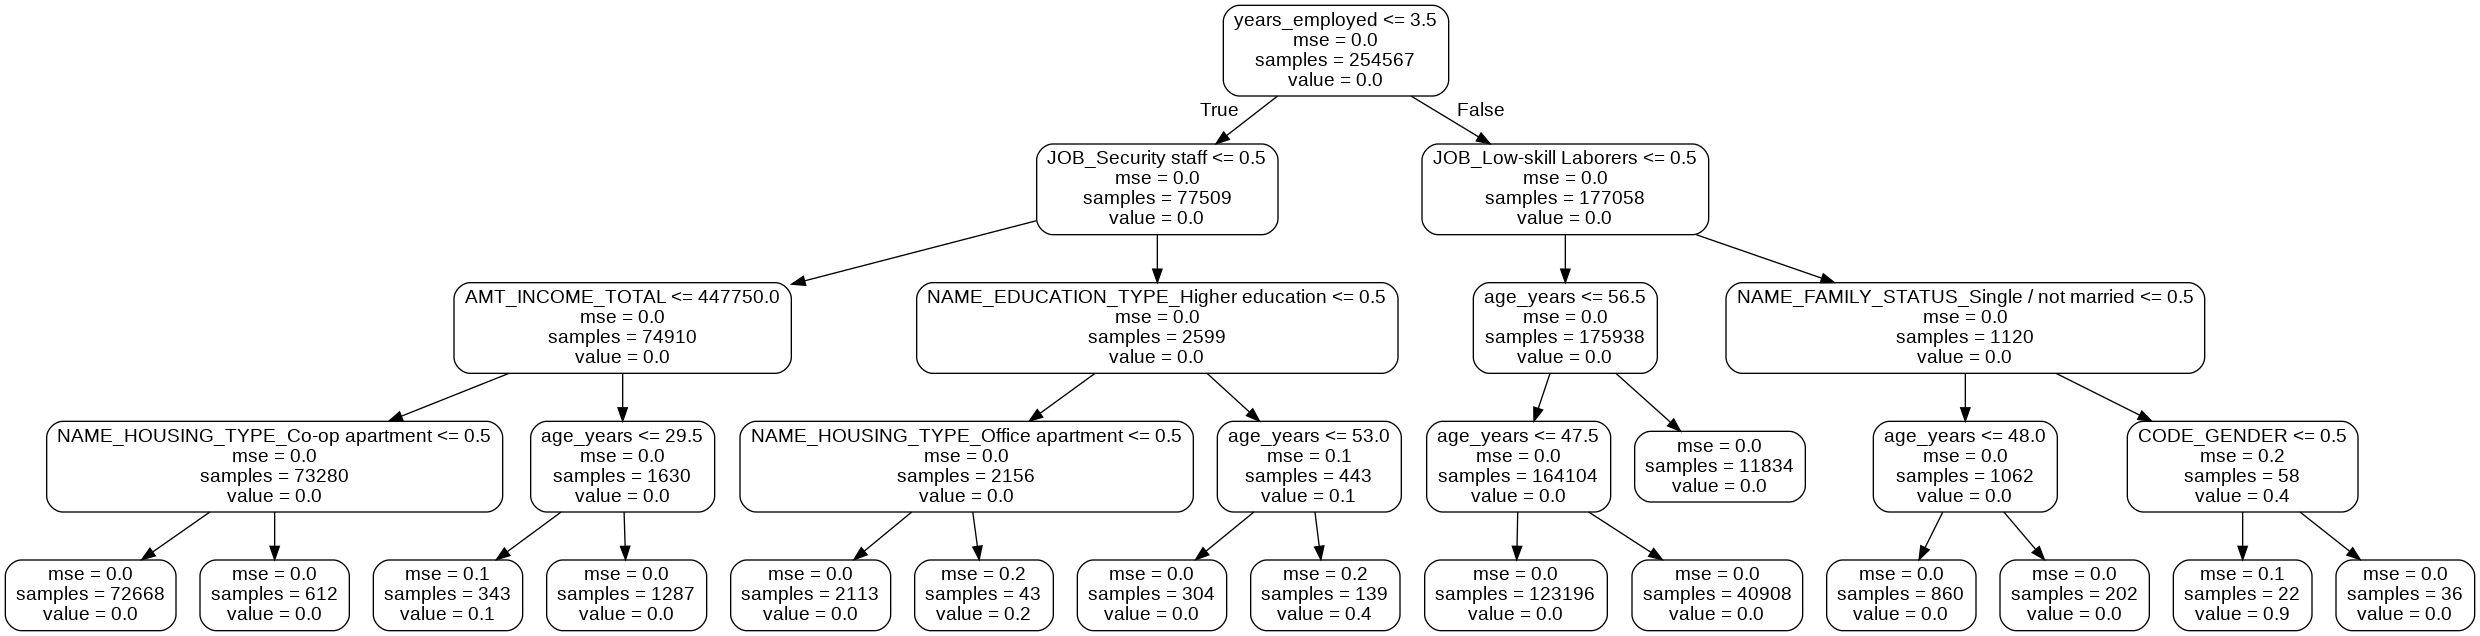

In [ ]:
random_forest_small = RandomForestRegressor(n_estimators=10, max_depth = 4)
random_forest_small.fit(train_features, train_target)

tree_small = random_forest_small.estimators_[5]

export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')
Image(graph.create_png())

In [ ]:
importances = list(random_forest.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: AMT_INCOME_TOTAL     Importance: 0.22
Variable: age_years            Importance: 0.22
Variable: years_employed       Importance: 0.11
Variable: FLAG_WORK_PHONE      Importance: 0.06
Variable: NAME_FAMILY_STATUS_Single / not married Importance: 0.05
Variable: CODE_GENDER          Importance: 0.04
Variable: NAME_EDUCATION_TYPE_Higher education Importance: 0.04
Variable: FLAG_PHONE           Importance: 0.03
Variable: NAME_EDUCATION_TYPE_Secondary / secondary special Importance: 0.03
Variable: JOB_Drivers          Importance: 0.03
Variable: NAME_FAMILY_STATUS_Married Importance: 0.02
Variable: JOB_Laborers         Importance: 0.02
Variable: FLAG_EMAIL           Importance: 0.01
Variable: NAME_FAMILY_STATUS_Separated Importance: 0.01
Variable: NAME_FAMILY_STATUS_Widow Importance: 0.01
Variable: NAME_HOUSING_TYPE_House / apartment Importance: 0.01
Variable: NAME_HOUSING_TYPE_Municipal apartment Importance: 0.01
Variable: NAME_HOUSING_TYPE_Office apartment Importance: 0.01
Variable

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]